# How to sell your visual art in Moscow? 

by Lana Samoilova

# Introduction 

To be an artist is not simple.   
Challenges, doubts, distrusts... and every day thougt: "Am I really talented?"

To make an art is not simple.   
Always looking for something new and inventing the way how to do that new idea.

To living by art is not only "not simple".   
You need money, you need sales as a proffment of you talent. But you don't want to part forever with your babies! And you don't know how to sell... and you think again: "Am I really talented?"  
And you have no time for it! All of you time you think about your art, you feel your art, you want to be in process of creating.

One of the simpliest way for visual artists to sell their arts is to put it somewhere "offline" to sell. Yes, in a real world. 
I don't mean Gallery here. Connect with Gallery is not simple. 
I mean coffee houses, pubs, bars - some place where people spend their money for a pleasure.

"No one have so many time to visit every cafe in the town", you'll say?  
No one have to.   
Data Science will help a lot here by finding places near by some art venues (what will increase the chance of selling)

### Target audience

1. Visual artists who want to find a place for selling their art.
2. Client-oriented Retail businesses who want to find a place for promoution.
3. Tourists and townspeople can use this data to find a place to visit.
4. Freelancer Data Scientists who want to produce a simple real-life project for selling.

# Data

I'm living at Moscow today, so the project will be done for this city.
I'll use the following data:
- Moscow administrative division data
    - Data source: https://github.com/datalanas/Moscow_walks/blob/master/Moscow_districts.xlsx
    - Description: This data contains names of Moscow okrugs, districts and population for every
           
 
- Moscow venues data
    - Data source: FourSquare API
    - Description: This data contains information of the most venues - names, categories, location, likes, etc.

### How it will be used to solve the problem

1. Create pandas data frame of Moscow administrative division.  
2. Add latitude and longitude values for every district using Nominatim.  
3. Get an information about Moscow venues using FourSquare.  
4. Create a data frame that contains only districts with art venues.  
5. Understanding the final data frame.  
6. Find similar groups by using K-means clustering.  
7. Analyze clusters.  
8. Make a recomendation "where to go".

# Methodology 

## Libraries

First of all, we need to import the required libraries for python.
- *pandas* and *numpy* for handling data
- *geopy* to get location 
- *request* for using FourSquare API
- *sklearn* for clustering
- *matplotlib* for visualization
- *folium* to visualize the results on a map

In [1]:
import numpy as np
import pandas as pd
import requests
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from geopy.geocoders import Nominatim

In [2]:
# pandas styling
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 100, 'display.max_rows', 100, 'colheader_justify', 'left', 'precision', 4)

In [3]:
# customizing print()
from IPython.display import display, Markdown
def printst(string):
    display(Markdown('<strong>{}</strong>'.format(string))) 
def printbd(string):
    display(Markdown('<bold>{}</bold>'.format(string)))

In [4]:
%matplotlib inline

#seaborn syling
sns.set_style('whitegrid', { 'axes.axisbelow': True, 'axes.edgecolor': 'black', 'axes.facecolor': 'white',
        'axes.grid': True, 'axes.labelcolor': 'black', 'axes.spines.bottom': True, 'axes.spines.left': True,
        'axes.spines.right': False, 'axes.spines.top': False, 'figure.facecolor': 'white', 
        'grid.color': 'grey', 'grid.linestyle': ':', 'image.cmap': 'rocket', 'lines.solid_capstyle': 'round',
        'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'text.color': 'black', 
        'xtick.top': False, 'xtick.bottom': True, 'xtick.color': 'navy', 'xtick.direction': 'out', 
        'ytick.right': False,    'ytick.left': True, 'ytick.color': 'navy', 'ytick.direction': 'out'})

# Creating pandas data frame of Moscow administrative division data. 

Let's take a first look to Moscow neighbourhoods:

In [5]:
df = pd.read_excel('...Moscow_districts.xlsx')
df.head()

,okrug,district,latitude,longitude,russian_name,population
0,Central Administrative Okrug,Arbat,55.7512,37.5899,Арбат,25699
1,Central Administrative Okrug,Basmanny,55.7673,37.6698,Басманный,100899
2,Central Administrative Okrug,Khamovniki,55.7292,37.5729,Хамовники,97110
3,Central Administrative Okrug,Krasnoselsky,55.7774,37.6542,Красносельский,45229
4,Central Administrative Okrug,Meshchansky,55.7792,37.6280,Мещанский,56077


In [6]:
printbd('There are {} okrugs at Moscow and {} districts'.format(df['okrug'].nunique(), df['district'].nunique()))

<bold>There are 12 okrugs at Moscow and 124 districts</bold>

First of all, I'll remove the information about "New Moscow", population, russian district names and truncate names of okrugs:

In [7]:
# deleting unnesessary columns
df = df.drop(['russian_name', 'population'], axis=1)

In [8]:
# truncating the names of okrugs
df['okrug'] = df['okrug'].str.split(" ", expand=True)[0]
# let's check
df['okrug'].value_counts().to_frame('districts per okrug').T

,North-Eastern,Northern,Southern,Eastern,Western,South-Eastern,South-Western,Central,North-Western,Zelenogradsky,Troitsky,Novomoskovsky
districts per okrug,17,16,16,16,13,12,12,10,8,2,1,1


In [9]:
df.tail()

,okrug,district,latitude,longitude
119,North-Western,Yuzhnoye Tushino,55.8524,37.4467
120,Zelenogradsky,Zelenograd,55.9964,37.1985
121,Zelenogradsky,Kryukovo,55.9763,37.1596
122,Novomoskovsky,Novomoskovsky,55.5502,37.3874
123,Troitsky,Troitsky,55.3535,37.1789


In [10]:
print('Data set has now {} okrugs which names are {}'.format(df['okrug'].nunique(), df['okrug'].unique()))

Data set has now 12 okrugs which names are ['Central' 'Northern' 'North-Eastern' 'Eastern' 'South-Eastern' 'Southern'
 'South-Western' 'Western' 'North-Western' 'Zelenogradsky' 'Novomoskovsky'
 'Troitsky']


How many districts?

In [11]:
df.shape[0]

124

Let's plot a map with okrug's markers

In [12]:
address = 'Red Square, Moscow, Russia'
geolocator = Nominatim(user_agent='myapp')
location = geolocator.geocode(address)
lat, lng = location.latitude, location.longitude

map = folium.Map(location=[lat, lng], zoom_start=10)

okrugs = df['okrug'].unique().tolist()
o = df['okrug'].nunique()
x=np.arange(len(okrugs))

for lt, ln, ok in zip(df['latitude'], df['longitude'], df['okrug']):
    label = folium.Popup(str(ok), parse_html=True)
    folium.CircleMarker([lt, ln], radius=7, popup=label, color='navy', fill=True, fill_color='navy', fill_opacity=0.5).add_to(map)

map

# Get an information about Moscow venues using FourSquare 

For using FourSquare API we'll also need following:

In [13]:
CLIENT_ID = '...' 
CLIENT_SECRET = '...' 
VERSION = '20180605' # Foursquare API version

address = 'Moscow, Russia'
geolocator = Nominatim(user_agent='myapp')
location = geolocator.geocode(address)
lat, lng = location.latitude, location.longitude

radius = 500
LIMIT = 100

In [ ]:
venues = []

for lat, lng, b, n in zip(df['latitude'], df['longitude'], df['okrug'], df['district']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues.append((b, n, lat, lng,
            venue['venue']['id'],
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))
        
tdf = pd.DataFrame(venues)

In [ ]:
writer = pd.ExcelWriter('.../Moscow_venues.xlsx')
tdf.to_excel(writer, 'venues', index=True)
writer.save()

Let's see what we get

In [15]:
vns = pd.read_excel('.../Moscow_venues.xlsx', index=False)
vns.head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8
0,0,Central,Arbat,55.7512,37.5899,57c027d7498e8532054695f3,Corner Café & Kitchen,55.7515,37.5868,Japanese Restaurant
1,1,Central,Arbat,55.7512,37.5899,4bf78ca6b182c9b659fc755a,Театр им. Вахтангова,55.7496,37.5916,Theater
2,2,Central,Arbat,55.7512,37.5899,5adffacc67e5f23195efb614,Шоколадница,55.7519,37.5883,Coffee Shop


In [16]:
vns = vns.drop('Unnamed: 0', axis=1)
vns.shape

(2129, 9)

Assigning column's names

In [17]:
vns.columns = ['okrug', 'district',  'lat', 'lng', 'id', 'venue', 'vlat', 'vlng', 'vcat']
vns.head(3)

,okrug,district,lat,lng,id,venue,vlat,vlng,vcat
0,Central,Arbat,55.7512,37.5899,57c027d7498e8532054695f3,Corner Café & Kitchen,55.7515,37.5868,Japanese Restaurant
1,Central,Arbat,55.7512,37.5899,4bf78ca6b182c9b659fc755a,Театр им. Вахтангова,55.7496,37.5916,Theater
2,Central,Arbat,55.7512,37.5899,5adffacc67e5f23195efb614,Шоколадница,55.7519,37.5883,Coffee Shop


In [18]:
print('We get an information about {} venues in Moscow'.format(vns.shape[0]))

We get an information about 2129 venues in Moscow


# Creating a data frame that contains only districts with art venues

In [19]:
print('Dataset contains {} unique categories of venues'.format(vns['vcat'].nunique()))

Dataset contains 274 unique categories of venues


In [20]:
#vns['vcat'].nunique()

Let's take a look

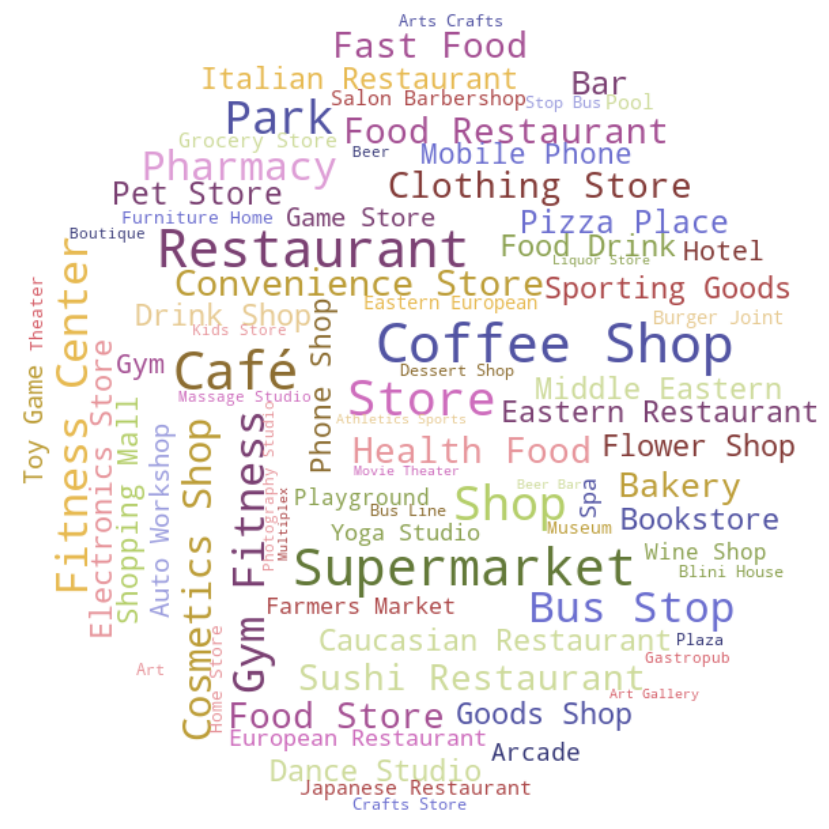

In [21]:
vcats = vns['vcat'].values 
text = ', '.join(vcats)

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
# stopwords.add('Restaurant') # you can add any words to stopwords

from PIL import Image 
mask = np.array(Image.open('.../images/round.png'))

wc = WordCloud(width=300, height=300, margin=0, max_font_size=40, min_font_size=10, max_words=2000, colormap='tab20b',
               background_color='white', mask=mask, contour_width=3, contour_color='white', stopwords=stopwords)
wc.generate(text)

fig = plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Now I'll choose the art-venues only

In [22]:
values = ['Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment', 'History Museum', 'Museum', 'Performing Arts Venue', 
          'Public Art', 'Sculpture Garden', 'Theater']

In [23]:
art = vns[vns['vcat'].str.contains('Art') | vns['vcat'].str.contains('Museum') | vns['vcat'].str.contains('Sculpture') | vns['vcat'].str.contains('Theater')  ]
art.shape

(73, 9)

What category exactly we get?

In [24]:
art['vcat'].nunique(), art['vcat'].unique()

(14, array(['Theater', 'Museum', 'Arts & Crafts Store', 'Art Gallery',
        'History Museum', 'Arts & Entertainment', 'Public Art',
        'Art Museum', 'Outdoor Sculpture', 'Movie Theater',
        'Sculpture Garden', 'Indie Movie Theater', 'Martial Arts Dojo',
        'Performing Arts Venue'], dtype=object))

We don't need martial arts and movies

In [25]:
art = art.loc[~vns['vcat'].str.contains('Movie | Dojo', regex=True)]

In [26]:
art['vcat'].nunique(), art['vcat'].unique()

(11, array(['Theater', 'Museum', 'Arts & Crafts Store', 'Art Gallery',
        'History Museum', 'Arts & Entertainment', 'Public Art',
        'Art Museum', 'Outdoor Sculpture', 'Sculpture Garden',
        'Performing Arts Venue'], dtype=object))

How many art-districts we have?

In [27]:
art['district'].nunique()

30

In [28]:
art.head()

,okrug,district,lat,lng,id,venue,vlat,vlng,vcat
1,Central,Arbat,55.7512,37.5899,4bf78ca6b182c9b659fc755a,Театр им. Вахтангова,55.7496,37.5916,Theater
6,Central,Arbat,55.7512,37.5899,4daac3fe1e72c1ab9bfb6528,Мемориальный музей А. Н. Скрябина,55.7508,37.5903,Museum
11,Central,Arbat,55.7512,37.5899,4c95ef9e82b56dcb892cddaa,Melnikov House (Дом Мельникова),55.7481,37.5895,Museum
17,Central,Arbat,55.7512,37.5899,4c9dfa51ca44236ad9c62599,Центральный дом актёра им. А. А. Яблочкиной,55.7492,37.5921,Theater
31,Central,Arbat,55.7512,37.5899,4e98381677c8d1cccb9f3cfa,Артэ,55.7507,37.5848,Arts & Crafts Store


Now the time to slice a main data by art-districts

In [29]:
vals = art['district'].unique().tolist()
vns = vns[vns['district'].isin(vals)]

Let's check how many districts in a main data set?

In [30]:
vns['district'].nunique()

30

Correct!

In [31]:
art.shape, vns.shape

((62, 9), (988, 9))

# Understanding the final data frame

So, what we have for now:

In [32]:
vns = vns.drop(['id', 'okrug'], axis=1)
vns.head()

,district,lat,lng,venue,vlat,vlng,vcat
0,Arbat,55.7512,37.5899,Corner Café & Kitchen,55.7515,37.5868,Japanese Restaurant
1,Arbat,55.7512,37.5899,Театр им. Вахтангова,55.7496,37.5916,Theater
2,Arbat,55.7512,37.5899,Шоколадница,55.7519,37.5883,Coffee Shop
3,Arbat,55.7512,37.5899,Спортивный комплекс «Арбат»,55.7509,37.5871,Pool
4,Arbat,55.7512,37.5899,Obedbufet (Обедбуфет),55.7523,37.5923,Buffet


Check for missing values:

In [33]:
vns.isnull().sum()

district    0
lat         0
lng         0
venue       0
vlat        0
vlng        0
vcat        0
dtype: int64

Good!
Chek for duplicates:

In [34]:
vns.duplicated().sum()

0

Excellent!
Let's see some summary statistics

In [35]:
temp = vns[['district', 'venue', 'vcat']]
temp.describe()

,district,venue,vcat
count,988,988,988
unique,30,864,208
top,Arbat,ВкусВилл,Coffee Shop
freq,100,9,53


This table tells us:
1. In 30 districts we have 884 venues in 208 categories
2. Most common venue category is 'Coffee Shop'

What is the top 10 in venue categories?

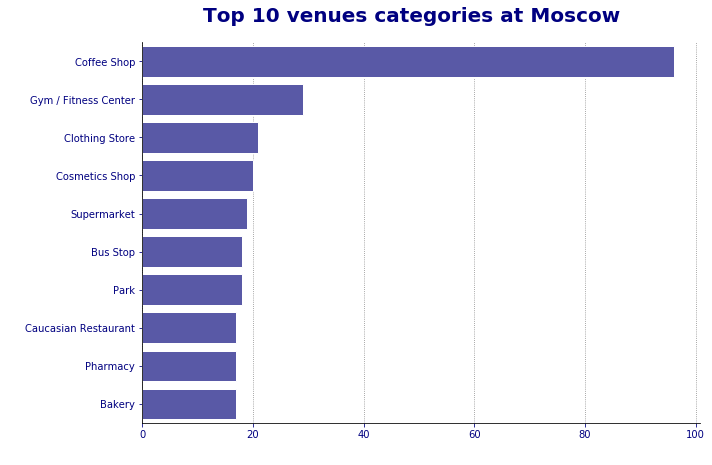

In [36]:
vns['vcat'] = vns['vcat'].replace({'Café':'Coffee Shop'}) 
tdf = vns.groupby('vcat')['venue'].agg(['count']).sort_values('count', ascending=False)
tdf = pd.DataFrame(tdf).reset_index().head(10)

fig = plt.figure(figsize=(10,7))
g = sns.barplot(x='count', y='vcat', data=tdf, color='blue', saturation=0.3) 

fig.suptitle('Top 10 venues categories at Moscow', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)
g.set_xlabel(' ',fontsize=14, color='navy')
g.set_ylabel(' ',fontsize=14, color='navy')
plt.show()

Try to sell anything with a coffee shop was a good idea, isn't it?

But how venues distributed by district?

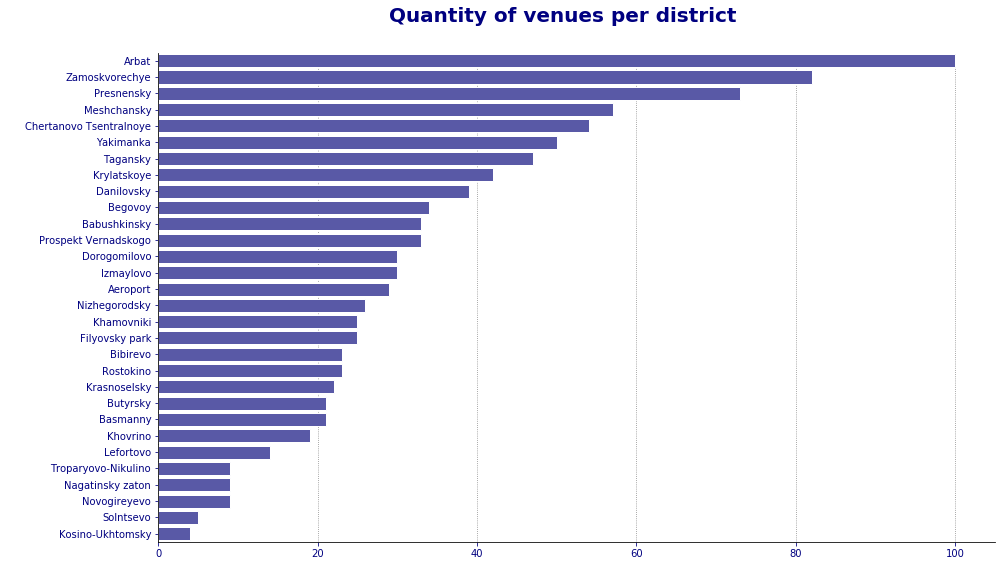

In [37]:
fig = plt.figure(figsize=(15,9))
fig.subplots_adjust(hspace=.8, wspace=.3)

order = vns['district'].value_counts().index
g = sns.countplot(y='district', data=vns, order=order, color='blue', saturation=0.3) 

fig.suptitle('Quantity of venues per district', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)
g.set_xlabel(' ',fontsize=14, color='navy')
g.set_ylabel(' ',fontsize=14, color='navy')
plt.show()

# K-means clustering

First of all, we need to prepare data for clustering

In [38]:
# one hot encoding
hotdf = pd.get_dummies(vns[['vcat']], prefix="", prefix_sep="")
hotdf['district'] = vns['district'] 
# move neighborhood column to the first column
cols = [hotdf.columns[-1]] + list(hotdf.columns[:-1])
hotdf = hotdf[cols]
hotdf.head(2)

,district,ATM,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Blini House,Board Shop,Bookstore,Botanical Garden,Boutique,Bridal Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,...,Roof Deck,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Arbat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arbat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It shold be 208 columns (208 minus "Café" plus "district")

In [39]:
hotdf.shape

(988, 208)

Correct.

Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each categor

In [40]:
gdf = hotdf.groupby('district').mean().reset_index()
gdf.head(3)

,district,ATM,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Bath House,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Trail,Blini House,Board Shop,Bookstore,Botanical Garden,Boutique,Bridal Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Camera Store,Candy Store,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,...,Roof Deck,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shawarma Place,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Squash Court,Stables,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tailor Shop,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Toy / Game Store,Track,Trail,Train Station,Tunnel,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Aeroport,0.0000,0.0000,0.0000,0.0345,0.1379,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0690,0.0000,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0345,0.0000,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0690,0.0000,0.1034,...,0.0000,0.0000,0.0000,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0345,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,Arbat,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0100,0.0200,0.0000,0.0100,0.0000,0.0100,0.0000,0.0000,0.0100,0.0000,0.0200,0.0000,0.0300,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0000,0.0100,0.0000,0.0100,0.0400,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0100,0.0000,0.0100,0.0000,0.1100,...,0.0000,0.0000,0.0200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0200,0.0200,0.0000,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0000,0.0000,0.0200,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100,0.0200,0.0000,0.0300,0.0000
2,Babushkinsky,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0606,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0606,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0303,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Should be 30 rows

In [41]:
gdf.shape

(30, 208)

In [42]:
gdf['district'].to_list()

['Aeroport',
 'Arbat',
 'Babushkinsky',
 'Basmanny',
 'Begovoy',
 'Bibirevo',
 'Butyrsky',
 'Chertanovo Tsentralnoye',
 'Danilovsky',
 'Dorogomilovo',
 'Filyovsky park',
 'Izmaylovo',
 'Khamovniki',
 'Khovrino',
 'Kosino-Ukhtomsky',
 'Krasnoselsky',
 'Krylatskoye',
 'Lefortovo',
 'Meshchansky',
 'Nagatinsky zaton',
 'Nizhegorodsky',
 'Novogireyevo',
 'Presnensky',
 'Prospekt Vernadskogo',
 'Rostokino',
 'Solntsevo',
 'Tagansky',
 'Troparyovo-Nikulino',
 'Yakimanka',
 'Zamoskvorechye']

Correct.  
Now, let's find the top 10 for each area

First, write a function to sort the venues

In [43]:
def freq(row, num):
    rcat = row.iloc[1:]
    rcat_sorted = rcat.sort_values(ascending=False)
    return rcat_sorted.index.values[0:num]

In [44]:
num=10 # finding a top 10
col = ['district']

for i in np.arange(num): 
    col.append('{}'.format(i+1))
        
ndf = pd.DataFrame(columns=col)
ndf['district'] = gdf['district']

for i in np.arange(gdf.shape[0]):
    ndf.iloc[i, 1:] = freq(gdf.iloc[i, :], num)

display(Markdown('<strong>{}</strong>'.format("Most common Moscow's venues per districts:")))
ndf.head()

<strong>Most common Moscow's venues per districts:</strong>

,district,1,2,3,4,5,6,7,8,9,10
0,Aeroport,Rental Car Location,Airport Service,Coffee Shop,Bakery,Clothing Store,Public Art,Dessert Shop,Dive Bar,Duty-free Shop,Sandwich Place
1,Arbat,Coffee Shop,Hotel,Burger Joint,Yoga Studio,Hostel,Museum,Bar,Bakery,Spa,Theater
2,Babushkinsky,Supermarket,Cosmetics Shop,Mobile Phone Shop,Coffee Shop,ATM,Bus Line,Beer Store,Blini House,Food & Drink Shop,Fast Food Restaurant
3,Basmanny,Park,History Museum,Recording Studio,Supermarket,Gun Range,Massage Studio,Theater,Flower Shop,Gym / Fitness Center,Public Art
4,Begovoy,Coffee Shop,Dance Studio,Gym / Fitness Center,Hotel,Hotel Bar,Furniture / Home Store,Pharmacy,Music Store,French Restaurant,Beer Store


In [45]:
k=5
clust = gdf.drop('district', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(clust)

# check cluster labels 
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 4, 0, 3, 0, 1,
       0, 0, 0, 1, 0, 0, 4, 0], dtype=int32)

Insert column with cluster's labels into the data frame

In [46]:
ndf.insert(0, 'Cluster', kmeans.labels_) # add clustering labels

Mergin all information

In [47]:
clustdf = pd.merge(ndf, df, on='district')

Take a look just to check evetything is going good:

In [48]:
clustdf.head()

,Cluster,district,1,2,3,4,5,6,7,8,9,10,okrug,latitude,longitude
0,0,Aeroport,Rental Car Location,Airport Service,Coffee Shop,Bakery,Clothing Store,Public Art,Dessert Shop,Dive Bar,Duty-free Shop,Sandwich Place,Northern,41.3042,2.0733
1,0,Arbat,Coffee Shop,Hotel,Burger Joint,Yoga Studio,Hostel,Museum,Bar,Bakery,Spa,Theater,Central,55.7512,37.5899
2,0,Babushkinsky,Supermarket,Cosmetics Shop,Mobile Phone Shop,Coffee Shop,ATM,Bus Line,Beer Store,Blini House,Food & Drink Shop,Fast Food Restaurant,North-Eastern,55.8672,37.6631
3,0,Basmanny,Park,History Museum,Recording Studio,Supermarket,Gun Range,Massage Studio,Theater,Flower Shop,Gym / Fitness Center,Public Art,Central,55.7673,37.6698
4,0,Begovoy,Coffee Shop,Dance Studio,Gym / Fitness Center,Hotel,Hotel Bar,Furniture / Home Store,Pharmacy,Music Store,French Restaurant,Beer Store,Northern,55.7819,37.5663


Map the clusters

In [49]:
clustdf = clustdf.reset_index()
clustdf.columns

Index(['index', 'Cluster', 'district', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', 'okrug', 'latitude', 'longitude'],
      dtype='object')

# Analyze clusters

In [50]:
# cluster 1
c1 = clustdf.loc[clustdf['Cluster'] == 0, clustdf.columns[[1,2,3,4,5,6]]]
c1

,Cluster,district,1,2,3,4
0,0,Aeroport,Rental Car Location,Airport Service,Coffee Shop,Bakery
1,0,Arbat,Coffee Shop,Hotel,Burger Joint,Yoga Studio
2,0,Babushkinsky,Supermarket,Cosmetics Shop,Mobile Phone Shop,Coffee Shop
3,0,Basmanny,Park,History Museum,Recording Studio,Supermarket
4,0,Begovoy,Coffee Shop,Dance Studio,Gym / Fitness Center,Hotel
5,0,Bibirevo,Fast Food Restaurant,Clothing Store,Italian Restaurant,Tennis Court
6,0,Butyrsky,Pharmacy,Supermarket,Liquor Store,Music Venue
7,0,Chertanovo Tsentralnoye,Clothing Store,Donut Shop,Fast Food Restaurant,Electronics Store
8,0,Danilovsky,Arcade,Clothing Store,Bus Stop,Middle Eastern Restaurant
9,0,Dorogomilovo,Boutique,Wine Shop,Coffee Shop,Roof Deck


In [51]:
# cluster 2
c2 = clustdf.loc[clustdf['Cluster'] == 1, clustdf.columns[[1,2,3,4,5,6]]]
c2

,Cluster,district,1,2,3,4
21,1,Novogireyevo,Bus Stop,Supermarket,Gym / Fitness Center,Yoga Studio
25,1,Solntsevo,Bus Stop,Cosmetics Shop,Art Gallery,Market


In [52]:
# cluster 3
c3 = clustdf.loc[clustdf['Cluster'] == 2, clustdf.columns[[1,2,3,4,5,6]]]
c3

,Cluster,district,1,2,3,4
14,2,Kosino-Ukhtomsky,Arts & Entertainment,Soccer Field,Eastern European Restaurant,Harbor / Marina


In [53]:
# cluster 4
c4 = clustdf.loc[clustdf['Cluster'] == 3, clustdf.columns[[1,2,3,4,5,6]]]
c4

,Cluster,district,1,2,3,4
19,3,Nagatinsky zaton,Bike Trail,Beach,Gym / Fitness Center,Eastern European Restaurant


In [54]:
# cluster 5
c5 = clustdf.loc[clustdf['Cluster'] == 4, clustdf.columns[[1,2,3,4,5,6]]]
c5

,Cluster,district,1,2,3,4
10,4,Filyovsky park,Coffee Shop,Bus Stop,Pedestrian Plaza,Park
17,4,Lefortovo,Coffee Shop,Performing Arts Venue,Pizza Place,Park
28,4,Yakimanka,Coffee Shop,Gym / Fitness Center,Restaurant,Art Gallery


# Make a recomendation "where to go".

Cluster 1 is our goal cluster.  
It contains following districts:

In [55]:
vals = c1['district'].values.tolist()
vals

['Aeroport',
 'Arbat',
 'Babushkinsky',
 'Basmanny',
 'Begovoy',
 'Bibirevo',
 'Butyrsky',
 'Chertanovo Tsentralnoye',
 'Danilovsky',
 'Dorogomilovo',
 'Izmaylovo',
 'Khamovniki',
 'Khovrino',
 'Krasnoselsky',
 'Krylatskoye',
 'Meshchansky',
 'Nizhegorodsky',
 'Presnensky',
 'Prospekt Vernadskogo',
 'Rostokino',
 'Tagansky',
 'Troparyovo-Nikulino',
 'Zamoskvorechye']

Let's slice the data by coffe venue only

In [56]:
result = vns[vns['district'].isin(c1['district'].values)]
result = result[result['vcat'].str.contains('Cof') | result['vcat'].str.contains('Caf')]
result.shape

(77, 7)

Some check

In [57]:
result['vcat'].unique()

array(['Coffee Shop', 'Cafeteria'], dtype=object)

Good.

And... voila - we're ready to make a final recommendation:

In [58]:
result = result[['venue', 'vlat', 'vlng', 'vcat']]
result.head()

,venue,vlat,vlng,vcat
2,Шоколадница,55.7519,37.5883,Coffee Shop
7,Кофемания,55.7522,37.5885,Coffee Shop
26,Holy Berry,55.7521,37.5855,Coffee Shop
30,Даблби,55.7529,37.5880,Coffee Shop
38,Surf Coffee,55.7525,37.5974,Coffee Shop


The "Where to go" map

In [62]:
map = folium.Map(location=[55.7512, 37.5899], zoom_start=11)

for i in range(0, len(result)):
    folium.Marker([result.iloc[i]['vlat'], result.iloc[i]['vlng']], 
                 popup=result.iloc[i]['venue']).add_to(map)
map

In [60]:
path='.../map_moscow_cafe.pdf'
map.save(path)

*If you click on marker, you'll see a venue's name*

# Results 

Someone can say what 77 venues to visit are too much. But in sales is considered a good exhaust 10%.  
So, if artist makes a deal with 7 Coffee Shops, it'll be a lucky.
Or the artist is really very tallented :-)

# Discussion 

As we can see on a map, the coffee venues have groups - big enough to find a venue to deal and to small enough to be possible to do for a real person.  
I reccomend to go for every venue on a map. But start with the biggest, of course

# Conclusion 

As we can see in this project, Data Science can help not only for business, but for individuals also.
The same way we can reccomend places to visit for any freelancers who produce something real for a retail sales.
Also, here is a room for improvement: 
- city can be clustering by postal codes, not by districts
- venues can be sorted by ratings
- a distance between art venues and coffe venues can be used for more detailed separation also

That's it!

It's been a challenging, but very interesting experiece.  
Please, tell me if you have any question.  
Thank you!  
Lana  